In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/HAR Dataset/HAR Mine")

In [105]:
!ls "/content/drive/My Drive/HAR Dataset/HAR Mine"
!cp "/content/drive/My Drive/HAR Dataset/HAR Mine/Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv" "accelerometer_extracted_featured_data_without_overlapping.csv"

 acc_data_4sec_before_3sec_after.csv
 acc_data_4sec_before_3sec_after_with_magnitude.csv
 accelerometer_extracted_featured_data_without_overlapping.csv
'Basic Data'
 checkpoint
 human_activity_recognition_basic.ipynb
 human_activity_recognition_Classifier.ipynb
 Human_activity_recognition_feature_extract.ipynb
 human_activity_recognition_MINE.ipynb
'Processed Data'


# Load Library

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as AB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import skew, kurtosis, iqr, median_absolute_deviation, entropy

from numpy.random import seed
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn
import tensorflow as tf

# Load Data

In [108]:
df = pd.read_csv('Processed Data/accelerometer_extracted_featured_data_without_overlapping.csv')
df.head()

,mean_x,mean_y,mean_z,magnitude_mean,std_x,std_y,std_z,magnitude_std,rms_x,rms_y,rms_z,magnitude_rms,min_x,min_y,min_z,magnitude_min,max_x,max_y,max_z,magnitude_max,median_x,median_y,median_z,magnitude_median,mad_x,mad_y,mad_z,magnitude_mad,corr_xy,corr_yz,corr_xz,subject,class
0,-1.644151,7.299989,-4.774019,9.194468,1.374718,1.303727,1.601727,0.633384,2.143148,7.415493,5.035552,9.216258,-3.890869,4.947205,-7.264801,7.616315,1.022034,10.116287,-0.647232,10.606999,-1.443993,7.268387,-4.960381,9.253738,1.145463,1.075877,1.239351,0.493521,0.803482,0.755901,0.724554,2,SITTING
1,-4.893322,2.375117,-8.347987,10.039573,0.647945,1.077232,0.453523,0.517292,4.936034,2.607989,8.360298,10.052891,-5.834961,0.261749,-9.491409,8.587557,-2.504623,5.095642,-7.202560,11.571552,-4.917984,1.873054,-8.333808,10.034463,0.466141,0.848993,0.334032,0.331420,0.147029,0.330089,0.287061,2,SITTING
2,-4.714092,1.146173,-8.771570,10.045569,0.542208,0.410817,0.462359,0.489795,4.745172,1.217573,8.783748,10.057503,-6.402389,-0.492416,-10.326981,9.372080,-3.649048,2.102890,-7.968704,12.089280,-4.677368,1.134445,-8.762375,9.961059,0.364911,0.280063,0.326969,0.301609,0.287382,0.298514,0.050644,2,SITTING
3,-4.440626,1.069510,-8.864417,9.972461,0.071734,0.047943,0.063884,0.049366,4.441206,1.070584,8.864647,9.972584,-4.570816,0.944107,-8.995804,9.865092,-4.271545,1.226624,-8.758789,10.071942,-4.436752,1.070999,-8.861740,9.964040,0.059195,0.035829,0.051725,0.042919,0.194947,0.208995,-0.454511,2,SITTING
4,-4.375648,0.917478,-8.933562,9.991692,0.120399,0.155448,0.059223,0.069623,4.377304,0.930554,8.933758,9.991934,-4.709686,0.434143,-9.072418,9.695230,-3.852570,1.159576,-8.753998,10.174546,-4.358940,0.938118,-8.938354,10.006441,0.077469,0.110670,0.045394,0.043270,-0.026265,0.537605,-0.009120,2,SITTING


# Data Exploration

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 33 columns):
mean_x              1261 non-null float64
mean_y              1261 non-null float64
mean_z              1261 non-null float64
magnitude_mean      1261 non-null float64
std_x               1261 non-null float64
std_y               1261 non-null float64
std_z               1261 non-null float64
magnitude_std       1261 non-null float64
rms_x               1261 non-null float64
rms_y               1261 non-null float64
rms_z               1261 non-null float64
magnitude_rms       1261 non-null float64
min_x               1261 non-null float64
min_y               1261 non-null float64
min_z               1261 non-null float64
magnitude_min       1261 non-null float64
max_x               1261 non-null float64
max_y               1261 non-null float64
max_z               1261 non-null float64
magnitude_max       1261 non-null float64
median_x            1261 non-null float64
median_y   

['SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS']


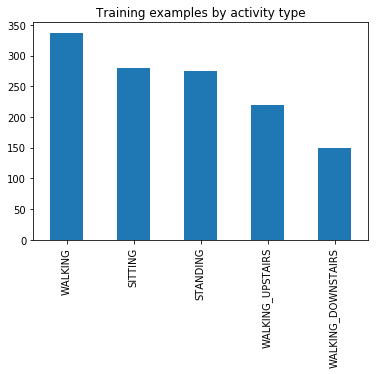

In [141]:
df['class'].value_counts().plot(kind='bar', title='Training examples by activity type');
unique_activities = np.unique(df['class'])
print(unique_activities)

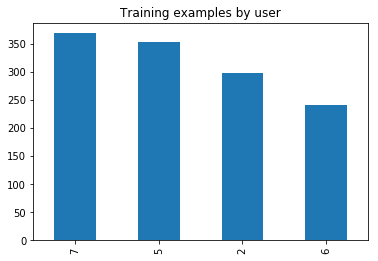

In [142]:
df['subject'].value_counts().plot(kind='bar', title='Training examples by user');

In [0]:
def plot_activity(subject, activity, df, activity_name):
  
  one_subject_segdata = df.loc[df['subject'] == subject]
  data = one_subject_segdata[one_subject_segdata['class'] == activity][['mean_x', 'mean_y',]][:100]
  axis = data.plot(subplots=True, figsize=(18, 14), 
                   title= 'Subject: '+str(subject) + ' Activity: '+activity_name)
  for ax in axis:
      ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

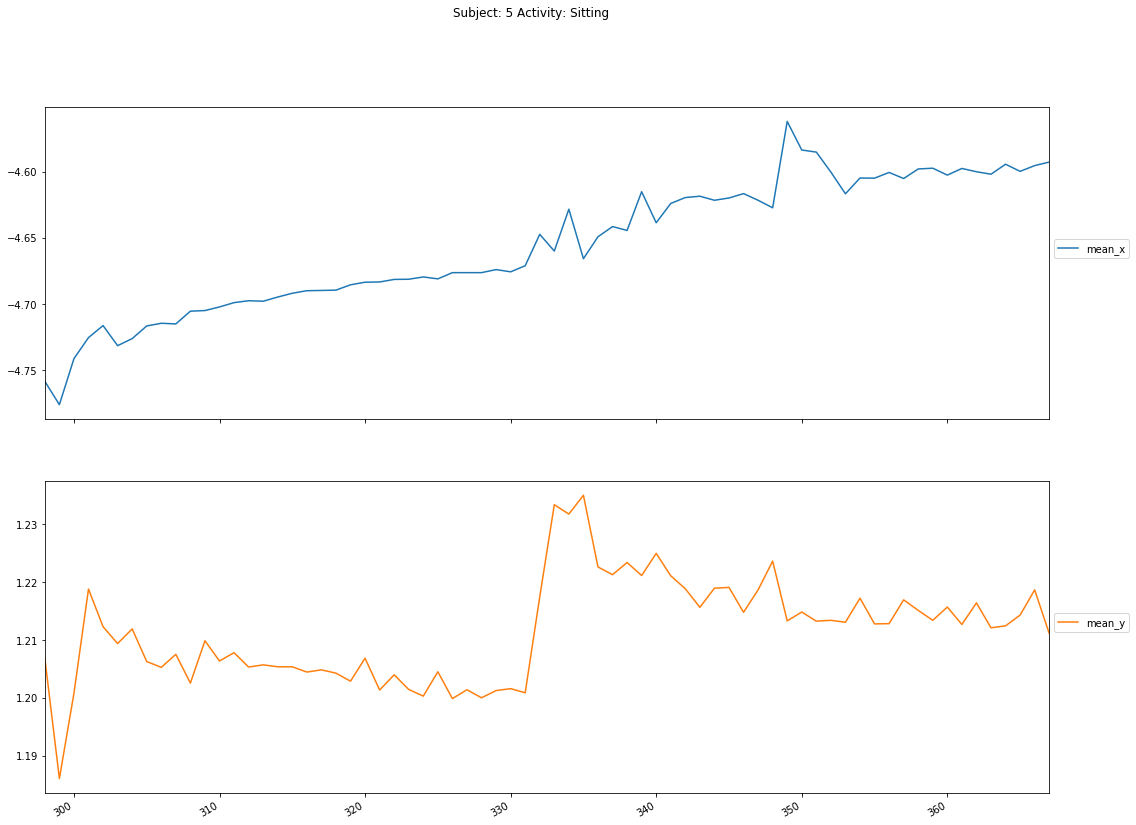

In [144]:
#plot_activity("Sitting", df)
plot_activity(5,"SITTING", df, "Sitting")

# Data Preprocessing

In [112]:
data = df.values
#print(data, data.shape)
X = data[:, 0:-2]
y= data[:, -1]
print(X, X.shape)
print (y, y.shape)

[[-1.64415131046 7.299988704000001 -4.7740188372 ... 0.8034815447440232
  0.7559010282155333 0.7245540302426258]
 [-4.89332215 2.3751165714000004 -8.347987354000002 ...
  0.1470292731461088 0.3300885734638331 0.2870609377851051]
 [-4.714092106000001 1.1461731014 -8.771570459999998 ...
  0.2873815417442005 0.2985143628736371 0.05064426729345066]
 ...
 [0.96825835968 8.02830476 -2.3171850598 ... 0.32853945084581604
  -0.12692960041915374 0.4639896550797898]
 [0.9066784702 9.043015800000003 -0.3414416522800001 ...
  0.1590691710722882 0.3865336003286277 -0.05064913068004599]
 [0.7591287654242423 8.958849410101008 -0.6778461196666665 ...
  0.3696767337550454 -0.002896245990085691 0.2837678319482947]] (1261, 31)
['SITTING' 'SITTING' 'SITTING' ... 'WALKING_UPSTAIRS' 'WALKING_UPSTAIRS'
 'WALKING_UPSTAIRS'] (1261,)


In [116]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(data[:,-1].astype('str'))+1
print(y)
print(len(y))

subjects = [2,5,6,7]

activity_ids = np.unique(y)
print(activity_ids)

n_class = len(activity_ids)
print(n_class)

[1 1 1 ... 5 5 5]
1261
[1 2 3 4 5]
5


In [0]:
def classification_report(cm):

  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos

  precision = true_pos / (true_pos+false_pos)
  recall = true_pos / (true_pos + false_neg)
  
  f1_score = 2/(precision**-1 + recall**-1)
  return precision, recall, f1_score

In [0]:
LABELS = ['SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Classifier

## KNN

fold # :  precision, recall, f1score, accuracy
length  298  =====  298
Testing Accuracy : 0.8087248322147651
fold 1 : 0.8333240807009594 0.8087248322147651 0.8013393966196773 0.8087248322147651
length  353  =====  353
Testing Accuracy : 0.71671388101983
fold 2 : 0.7942894848669174 0.71671388101983 0.7236862946463705 0.71671388101983
length  241  =====  241
Testing Accuracy : 0.8298755186721992
fold 3 : 0.8490253594494055 0.8298755186721992 0.8187452272015961 0.8298755186721992
length  369  =====  369
Testing Accuracy : 0.7398373983739838
fold 4 : 0.7922601642930144 0.7398373983739838 0.7521875610032651 0.7398373983739838
overall: 0.7790493462880764 0.7668517049960349 0.7711130741909166 0.7668517049960349
class-wise precision: [1.         0.98888889 0.71821306 0.56024096 0.47692308]
class-wise recall: [0.97857143 0.97090909 0.62017804 0.62416107 0.56363636]
class-wise f1score: [0.98916968 0.97981651 0.6656051  0.59047619 0.51666667]
class-wise accuracy: [0.97857143 0.97090909 0.62017804

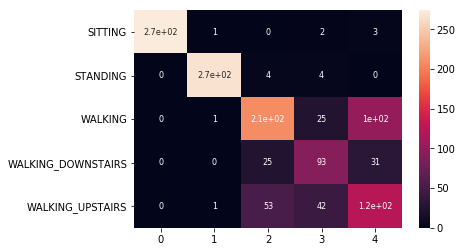

In [122]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  #print(train_x, type(train_x), train_x.shape)
  #print(train_y, type(train_y), train_y.shape)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
  clf.fit(train_x, train_y)
  #print(train_x[0],train_x[0].shape,train_x.shape)
  
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  #print(test_x, type(test_x), test_x.shape)
  #print(test_y, type(test_y), test_y.shape)
  
  true, pred = [], []
  
  for row_test in test_x:
    #ts_x = mmscaler.transform(test_x)
    #print("row test ",row_test, row_test.reshape(1,-1).shape)
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  #print("predicted probability ", pred_proba, type(pred_proba), len(pred_proba))
  #print("predicted activity ", )
  
  #print('length ' , len(list(test_y)),' ===== ', len(pred))
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Decission Tree

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.8624161073825504
fold 1 : 0.8737439529165283 0.8624161073825504 0.8627384490786135 0.8624161073825504
Testing Accuracy : 0.7110481586402266
fold 2 : 0.7802671507283845 0.7110481586402266 0.7237538801736426 0.7110481586402266
Testing Accuracy : 0.8340248962655602
fold 3 : 0.8557796042132142 0.8340248962655602 0.8356971773630008 0.8340248962655602
Testing Accuracy : 0.7723577235772358
fold 4 : 0.7913996157779734 0.7723577235772358 0.7776203872296521 0.7723577235772358
overall: 0.7995576337708824 0.7882632831086439 0.791975921861564 0.7882632831086439
class-wise precision: [1.         0.97454545 0.78546713 0.53703704 0.52509653]
class-wise recall: [0.98571429 0.97454545 0.6735905  0.58389262 0.61818182]
class-wise f1score: [0.99280576 0.97454545 0.72523962 0.55948553 0.56784969]
class-wise accuracy: [0.98571429 0.97454545 0.6735905  0.58389262 0.61818182]
[[276   1   0   2   1]
 [  0 268   1   3   3]
 [  0   3 227  21  86

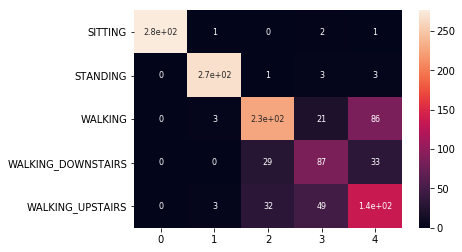

In [123]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  #print(train_x, type(train_x), train_x.shape)
  #print(train_y, type(train_y), train_y.shape)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = DT(max_leaf_nodes=20, random_state=42)
  clf.fit(train_x, train_y)
  #print(train_x[0],train_x[0].shape,train_x.shape)
  
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  #print(test_x, type(test_x), test_x.shape)
  #print(test_y, type(test_y), test_y.shape)
  
  true, pred = [], []
  
  for row_test in test_x:
    #ts_x = mmscaler.transform(test_x)
    #print("row test ",row_test, row_test.reshape(1,-1).shape)
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  #print("predicted probability ", pred_proba, type(pred_proba), len(pred_proba))
  #print("predicted activity ", )
  
  #print('length ' , len(list(test_y)),' ===== ', len(pred))
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Random Forest

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.8590604026845637
fold 1 : 0.8754392392625777 0.8590604026845637 0.8596381122913008 0.8590604026845637
Testing Accuracy : 0.8385269121813032
fold 2 : 0.8738598351377176 0.8385269121813032 0.8411442330569698 0.8385269121813032
Testing Accuracy : 0.8672199170124482
fold 3 : 0.8742551399245 0.8672199170124482 0.8590954172838596 0.8672199170124482
Testing Accuracy : 0.7831978319783198
fold 4 : 0.811615684595544 0.7831978319783198 0.7924226158596464 0.7831978319783198
overall: 0.8370706474176751 0.8326724821570183 0.8342996609029883 0.8326724821570183
class-wise precision: [1.         0.98168498 0.82075472 0.53642384 0.67755102]
class-wise recall: [0.97857143 0.97454545 0.77448071 0.54362416 0.75454545]
class-wise f1score: [0.98916968 0.97810219 0.79694656 0.54       0.71397849]
class-wise accuracy: [0.97857143 0.97454545 0.77448071 0.54362416 0.75454545]
[[274   1   0   2   3]
 [  0 268   2   4   1]
 [  0   3 261  36  37]
 

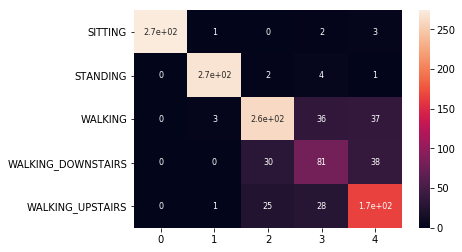

In [124]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  #print(train_x, type(train_x), train_x.shape)
  #print(train_y, type(train_y), train_y.shape)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = RF(n_estimators=100, max_depth=5, random_state=42)
  clf.fit(train_x, train_y)
  #print(train_x[0],train_x[0].shape,train_x.shape)
  
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  #print(test_x, type(test_x), test_x.shape)
  #print(test_y, type(test_y), test_y.shape)
  
  true, pred = [], []
  
  for row_test in test_x:
    #ts_x = mmscaler.transform(test_x)
    #print("row test ",row_test, row_test.reshape(1,-1).shape)
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  
  #print("predicted probability ", pred_proba, type(pred_proba), len(pred_proba))
  #print("predicted activity ", )
  
  #print('length ' , len(list(test_y)),' ===== ', len(pred))
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Gaussian Naive Bayes

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.7483221476510067
fold 1 : 0.7433715131058147 0.7483221476510067 0.741135745565024 0.7483221476510067
Testing Accuracy : 0.6827195467422096
fold 2 : 0.7501124647495554 0.6827195467422096 0.7038145451696294 0.6827195467422096
Testing Accuracy : 0.7676348547717843
fold 3 : 0.7906410216412401 0.7676348547717843 0.7499096932571736 0.7676348547717843
Testing Accuracy : 0.7723577235772358
fold 4 : 0.800390979145793 0.7723577235772358 0.7785979155931628 0.7723577235772358
overall: 0.7476466466312504 0.7406819984139572 0.7424538696090207 0.7406819984139572
class-wise precision: [1.         1.         0.815625   0.11382114 0.43617021]
class-wise recall: [0.96785714 0.96363636 0.77448071 0.09395973 0.55909091]
class-wise f1score: [0.98366606 0.98148148 0.79452055 0.10294118 0.49003984]
class-wise accuracy: [0.96785714 0.96363636 0.77448071 0.09395973 0.55909091]
[[271   0   0   7   2]
 [  0 265   0  10   0]
 [  0   0 261  27  49]

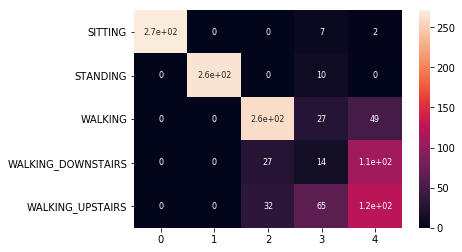

In [127]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = GaussianNB()
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Linear Model

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing Accuracy : 0.8523489932885906
fold 1 : 0.874104929474057 0.8523489932885906 0.8556920730347156 0.8523489932885906


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the 

Testing Accuracy : 0.5297450424929179
fold 2 : 0.7466387842548374 0.5297450424929179 0.47742069906187135 0.5297450424929179


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing Accuracy : 0.8298755186721992
fold 3 : 0.8114459476736753 0.8298755186721992 0.8174991583517325 0.8298755186721992


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing Accuracy : 0.7154471544715447
fold 4 : 0.8541586451593636 0.7154471544715447 0.6963642307626027 0.7154471544715447
overall: 0.7706671483328413 0.7176843774781919 0.7202734944877596 0.7176843774781919
class-wise precision: [0.96153846 0.94014085 0.67251462 0.30630631 0.78074866]
class-wise recall: [0.98214286 0.97090909 0.34124629 0.68456376 0.66363636]
class-wise f1score: [0.97173145 0.95527728 0.45275591 0.42323651 0.71744472]
class-wise accuracy: [0.98214286 0.97090909 0.34124629 0.68456376 0.66363636]
[[275   1   2   0   2]
 [  0 267   1   5   2]
 [  1   1 115 191  29]
 [  0   1  38 102   8]
 [ 10  14  15  35 146]]


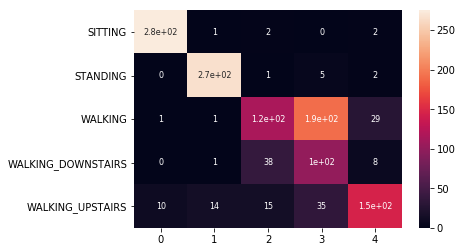

In [128]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = linear_model.LogisticRegression(penalty='l1')
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## MLP Classifier

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.8456375838926175
fold 1 : 0.8718111694858636 0.8456375838926175 0.8461716635476204 0.8456375838926175


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.8413597733711048
fold 2 : 0.8762738742081039 0.8413597733711048 0.8416669304114489 0.8413597733711048
Testing Accuracy : 0.7925311203319502
fold 3 : 0.8524377593360996 0.7925311203319502 0.7894296627218397 0.7925311203319502


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.7452574525745257
fold 4 : 0.8167774350118749 0.7452574525745257 0.7545756395525466 0.7452574525745257
overall: 0.8130733332096264 0.8049167327517843 0.8074901556852467 0.8049167327517843
class-wise precision: [0.99636364 0.96071429 0.79931973 0.50877193 0.62240664]
class-wise recall: [0.97857143 0.97818182 0.69732938 0.58389262 0.68181818]
class-wise f1score: [0.98738739 0.96936937 0.74484945 0.54375    0.65075922]
class-wise accuracy: [0.97857143 0.97818182 0.69732938 0.58389262 0.68181818]
[[274   1   1   1   3]
 [  0 269   2   4   0]
 [  0   3 235  37  62]
 [  0   1  35  87  26]
 [  1   6  21  42 150]]


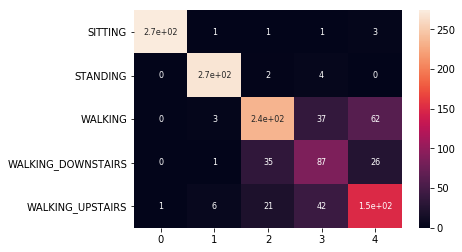

In [129]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = MLPClassifier(alpha=5,hidden_layer_sizes=(300, 6), random_state=1,solver='adam')
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.7785234899328859
fold 1 : 0.8023777594776268 0.7785234899328859 0.7715163007536091 0.7785234899328859


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.6827195467422096
fold 2 : 0.7596334711800425 0.6827195467422096 0.6796770367340639 0.6827195467422096


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.8464730290456431
fold 3 : 0.8445430859789635 0.8464730290456431 0.8284148745963491 0.8464730290456431


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Testing Accuracy : 0.6964769647696477
fold 4 : 0.7440626430871674 0.6964769647696477 0.6899038476091216 0.6964769647696477
overall: 0.7345252716198943 0.7406819984139572 0.7336895563488585 0.7406819984139572
class-wise precision: [0.98916968 0.96415771 0.68965517 0.17094017 0.5738255 ]
class-wise recall: [0.97857143 0.97818182 0.59347181 0.13422819 0.77727273]
class-wise f1score: [0.98384201 0.97111913 0.63795853 0.15037594 0.66023166]
class-wise accuracy: [0.97857143 0.97818182 0.59347181 0.13422819 0.77727273]
[[274   1   2   0   3]
 [  1 269   4   1   0]
 [  0   4 200  80  53]
 [  0   0  58  20  71]
 [  2   5  26  16 171]]


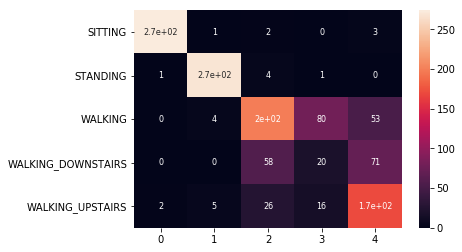

In [130]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = MLPClassifier(alpha=5,hidden_layer_sizes=(300, 6), random_state=1, solver ='sgd',max_iter=500 )
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Ada Boost

fold # :  precision, recall, f1score, accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing Accuracy : 0.6342281879194631
fold 1 : 0.5361508228371795 0.6342281879194631 0.5592602069896484 0.6342281879194631


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing Accuracy : 0.7280453257790368
fold 2 : 0.5716112211386598 0.7280453257790368 0.6287360346309323 0.7280453257790368


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing Accuracy : 0.7178423236514523
fold 3 : 0.5958236345848935 0.7178423236514523 0.6327165933788108 0.7178423236514523


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  # Remove the CWD from sys.path while we load stuff.


Testing Accuracy : 0.4959349593495935
fold 4 : 0.3110302006555639 0.4959349593495935 0.3611301595869976 0.4959349593495935
overall: 0.5456290764778784 0.6360031720856463 0.5558153905098131 0.6360031720856463
class-wise precision: [0.99280576 0.96969697 0.42547771        nan        nan]
class-wise recall: [0.98571429 0.69818182 0.99109792 0.         0.        ]
class-wise f1score: [0.98924731 0.81183932 0.59536542        nan        nan]
class-wise accuracy: [0.98571429 0.69818182 0.99109792 0.         0.        ]
[[276   1   3   0   0]
 [  2 192  81   0   0]
 [  0   3 334   0   0]
 [  0   0 149   0   0]
 [  0   2 218   0   0]]


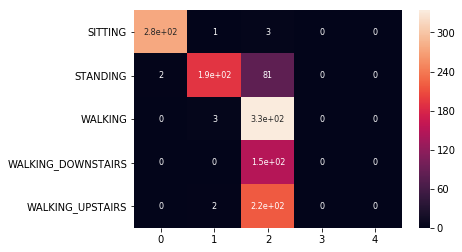

In [131]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = AB(n_estimators=100, random_state=42)
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## Gradient Boost

fold # :  precision, recall, f1score, accuracy
Testing Accuracy : 0.9161073825503355
fold 1 : 0.9279764053816569 0.9161073825503355 0.9179296323139703 0.9161073825503355
Testing Accuracy : 0.830028328611898
fold 2 : 0.85778371664632 0.830028328611898 0.8365009280062518 0.830028328611898
Testing Accuracy : 0.8879668049792531
fold 3 : 0.8952282157676349 0.8879668049792531 0.8878451553282036 0.8879668049792531
Testing Accuracy : 0.7804878048780488
fold 4 : 0.8171647587838557 0.7804878048780488 0.7884843347474075 0.7804878048780488
overall: 0.8560980546062322 0.8469468675654243 0.8503106435233444 0.8469468675654243
class-wise precision: [1.         0.98884758 0.86513158 0.54705882 0.70247934]
class-wise recall: [0.98571429 0.96727273 0.78041543 0.62416107 0.77272727]
class-wise f1score: [0.99280576 0.97794118 0.82059282 0.5830721  0.73593074]
class-wise accuracy: [0.98571429 0.96727273 0.78041543 0.62416107 0.77272727]
[[276   0   0   3   1]
 [  0 266   5   1   3]
 [  0   0 263  44  30]
 [

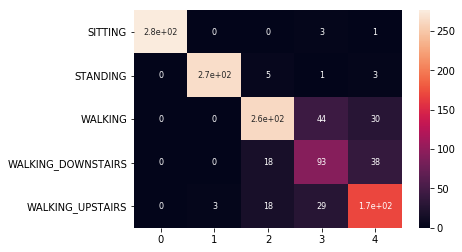

In [132]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = GB(n_estimators=100, random_state=42)
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  
  
  Predictions_test = clf.predict(test_x)
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("Testing Accuracy : {}".format(TestAccuracy))
  
  print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(true, pred)

ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
ov_accuracy = accuracy_score(true_all, pred_all)

print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))



array = confusion_matrix(true_all, pred_all)
df_cm = pd.DataFrame(array, range(5),range(5))
#sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8},yticklabels=('SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'))# font size
plt.show()

## SVM

In [140]:
cm_all = np.zeros((n_class,n_class))
true_all, pred_all = [], []
fold_result = []

print("fold # :  precision, recall, f1score, accuracy")

for f, sub in enumerate(subjects[:]):
  
  train_data = (df.loc[df['subject'] != sub]).values
  test_data = (df.loc[df['subject'] == sub]).values
  
  le = preprocessing.LabelEncoder()
  train_y = le.fit_transform(train_data[:,-1].astype('str'))+1
  
  train_x = train_data[: , :-2 ].astype(float)
  train_y = train_y.astype(int)
  
  mmscaler = MinMaxScaler()
  #mmscaler.fit(train_x)
  #train_x = mmscaler.transform(train_x)
  #print(train_x)
  
  clf = svm.SVC(gamma='auto')
  clf.fit(train_x, train_y)
  
  
  le = preprocessing.LabelEncoder()
  test_y = le.fit_transform(test_data[:,-1].astype('str'))+1
  
  test_x = test_data[: , :-2 ].astype(float)
  test_y = test_y.astype(int)
  
  true, pred = [], []
  
  '''
  for row_test in test_x:
    pred_proba = clf.predict_proba(row_test.reshape(1,-1))
    #pred_proba = np.mean(pred_proba, axis=0)
    pred += [activity_ids[np.argmax(pred_proba)]]
  
  true = list(test_y)
  
  true_all += true
  pred_all += pred
  
  precision, recall, f1score, _ = precision_recall_fscore_support(true, pred, average='weighted')  
  accuracy = accuracy_score(true, pred)
  fold_result += [precision, recall, f1score, accuracy]
  '''
  
  Predictions_test = clf.predict(test_x)
  #print(Predictions_test, type(Predictions_test))
  TestAccuracy = accuracy_score(y_true = test_y, y_pred = Predictions_test)
  print("fold", f+1,":","Testing Accuracy : {}".format(TestAccuracy))
  
  ar = confusion_matrix(test_y, Predictions_test)
  #print(ar, type (ar), ar.shape)
  
  #print("fold", f+1,":", precision,recall,f1score,accuracy)
  cm_all += confusion_matrix(test_y, Predictions_test)
  print(cm_all)

#ov_precision, ov_recall, ov_f1score, _ = precision_recall_fscore_support(true_all, pred_all, average='weighted')
#ov_accuracy = accuracy_score(true_all, pred_all)

#print("overall:", ov_precision, ov_recall, ov_f1score,ov_accuracy)

class_prec, class_rec, class_f1 = classification_report(cm_all)
class_acc = cm_all.diagonal()/np.sum(cm_all, axis=1)
print('class-wise precision:',class_prec)
print('class-wise recall:',class_rec)
print('class-wise f1score:',class_f1)
print('class-wise accuracy:',class_acc)

print(cm_all.astype('int'))





fold # :  precision, recall, f1score, accuracy
fold 1 : Testing Accuracy : 0.825503355704698
[[69.  0.  5.  0.  1.]
 [ 0. 73.  4.  0.  0.]
 [ 0.  0. 46.  0.  0.]
 [ 0.  0.  5. 37.  2.]
 [ 0.  0. 28.  7. 21.]]
fold 2 : Testing Accuracy : 0.6487252124645893
[[139.   0.   5.   0.   1.]
 [  0. 130.   4.   0.   0.]
 [  0.   0. 117.   2.  57.]
 [  0.   0.  10.  68.   8.]
 [  0.   0.  82.   7.  21.]]
fold 3 : Testing Accuracy : 0.5643153526970954
[[139.   0.  62.   0.   1.]
 [  0. 190.   4.   0.   2.]
 [  0.   0. 172.   2.  57.]
 [  0.   0.  26.  68.   9.]
 [  0.   0. 103.  15.  42.]]
fold 4 : Testing Accuracy : 0.5067750677506775
[[139.   0. 138.   0.   3.]
 [  0. 262.  11.   0.   2.]
 [  0.   0. 232.   9.  96.]
 [  0.   0.  34.  78.  37.]
 [  0.   1. 104.  28.  87.]]
class-wise precision: [1.         0.99619772 0.44701349 0.67826087 0.38666667]
class-wise recall: [0.49642857 0.95272727 0.6884273  0.52348993 0.39545455]
class-wise f1score: [0.66348449 0.9739777  0.54205607 0.59090909 0.39101